In [1]:
import torch
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import csv

import dataset
import datasplit
import model.models as models
import trainer
import utils

In [2]:
models_folder = '../../saved/models'
model_name = '20201012_setnetcond_mono_best'
results_folder = '../../saved/results'
results_subfolder = '20201012_setnetcond_mono'

In [3]:
# load model
setnetcond = torch.load('%s/%s' % (models_folder, model_name), map_location=torch.device('cpu'))

In [4]:
all_train_losses = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_train_losses.npy')), allow_pickle=True)
all_train_correct = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_train_correct.npy')), allow_pickle=True)
best_train_results = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'best_train_results.npy')), allow_pickle=True)

all_val_losses = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_val_losses.npy')), allow_pickle=True)
all_val_correct = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_val_correct.npy')), allow_pickle=True)
best_val_results = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'best_val_results.npy')), allow_pickle=True)

all_test_losses = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_test_losses.npy')), allow_pickle=True)
all_test_correct = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_test_correct.npy')), allow_pickle=True)
best_test_results = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'best_test_results.npy')), allow_pickle=True)

fx_labels = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'fx_labels.npy')), allow_pickle=True)

In [5]:
train_set_size = best_train_results.shape[0]
val_set_size = best_val_results.shape[0]
test_set_size = best_test_results.shape[0]

In [6]:
# BEST RESULTS
print('Best Train Accuracy: ', 100 * max(all_train_correct) / train_set_size)
print('Epoch: ', np.argmax(all_train_correct))
print()
print('Best Val Accuracy: ', 100 * max(all_val_correct) / val_set_size)
print('Epoch: ', np.argmax(all_val_correct))
print()
print('Best Test Accuracy: ', 100 * max(all_test_correct) / test_set_size)
print('Epoch: ', np.argmax(all_test_correct))
print()

Best Train Accuracy:  78.53386684337063
Epoch:  49

Best Val Accuracy:  73.27012768560287
Epoch:  49

Best Test Accuracy:  73.33781882683957
Epoch:  49



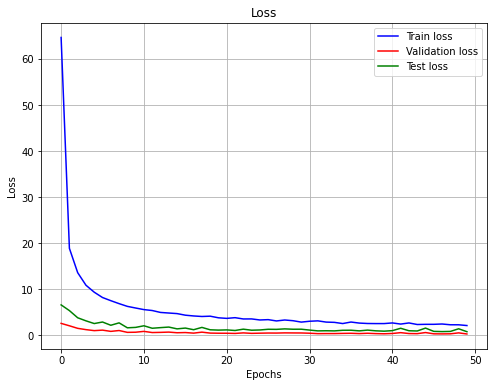

In [7]:
# LOSS
epochs = range(0, len(all_train_losses))
plt.figure(figsize=(8,6))
plt.grid(b=None, which='major', axis='both')
plt.plot(epochs, all_train_losses, 'b', label='Train loss')
plt.plot(epochs, all_val_losses, 'r', label='Validation loss')
plt.plot(epochs, all_test_losses, 'g', label='Test loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

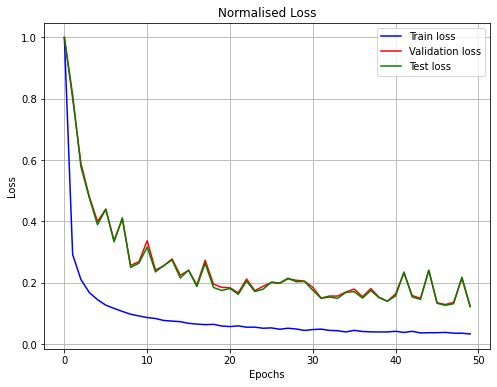

In [8]:
# NORMALISED LOSS
epochs = range(0, len(all_train_losses))
plt.figure(figsize=(8,6))
plt.grid(b=None, which='major', axis='both')
plt.plot(epochs, np.array(all_train_losses) / max(all_train_losses), 'b', label='Train loss')
plt.plot(epochs, np.array(all_val_losses) / max(all_val_losses), 'r', label='Validation loss')
plt.plot(epochs, np.array(all_test_losses) / max(all_test_losses), 'g', label='Test loss')
plt.title('Normalised Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

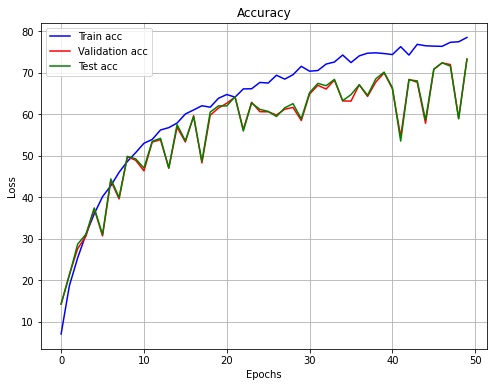

In [9]:
# ACCURACY
all_train_perc_correct = 100 * np.array(all_train_correct) / train_set_size
all_val_perc_correct = 100 * np.array(all_val_correct) / val_set_size
all_test_perc_correct = 100 * np.array(all_test_correct) / test_set_size
epochs = range(0, len(all_train_losses))
plt.figure(figsize=(8,6))
plt.grid(b=None, which='major', axis='both')
plt.plot(epochs, all_train_perc_correct, 'b', label='Train acc')
plt.plot(epochs, all_val_perc_correct, 'r', label='Validation acc')
plt.plot(epochs, all_test_perc_correct, 'g', label='Test acc')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
# example
best_train_results[0]

array([101150, 'G91-54304-MT2-G2B0T0ML10MF0-21091',
       array([1.   , 0.218, 0.076, 0.052, 0.985, 0.018], dtype=float32),
       array([1. , 0.2, 0. , 0. , 1. , 0. ], dtype=float32)], dtype=object)

In [11]:
# Find best performance epoch based on validation
# Extract results from training and test for that epoch
best_val = 100 * max(all_val_correct) / val_set_size
best_val_idx = np.argmax(all_val_correct)

print("Best Validation Accuracy: ",best_val, "at epoch ", best_val_idx)
print("Training Accuracy: ", 100 * all_train_correct[best_val_idx] / train_set_size)
print("Test Accuracy: ", 100 * all_test_correct[best_val_idx] / test_set_size)

Best Validation Accuracy:  73.27012768560287 at epoch  49
Training Accuracy:  78.53386684337063
Test Accuracy:  73.33781882683957


In [12]:
# extract vectors for dataframe
train_indexes = best_train_results[:, 0]
train_filenames = best_train_results[:, 1] 
train_preds = np.stack(best_train_results[:, 2])
train_targets = np.stack(best_train_results[:, 3])
train_abs_err = np.stack(abs(train_preds - train_targets))

val_indexes = best_val_results[:, 0]
val_filenames = best_val_results[:, 1] 
val_preds = np.stack(best_val_results[:, 2])
val_targets = np.stack(best_val_results[:, 3])
val_abs_err = np.stack(abs(val_preds - val_targets))

test_indexes = best_test_results[:, 0]
test_filenames = best_test_results[:, 1] 
test_preds = np.stack(best_test_results[:, 2])
test_targets = np.stack(best_test_results[:, 3])
test_abs_err = np.stack(abs(test_preds - test_targets))

In [13]:
# dataframes
train_df = pd.DataFrame(data={'index': train_indexes, 'filename': train_filenames,
                                'level_pred': train_preds[:,0], 'gain_pred': train_preds[:,1],
                                'tone_eq1_pred': train_preds[:,2], 'tone_eq2_pred': train_preds[:,3],
                                'tone_eq3_pred': train_preds[:,4], 'tone_eq4_pred': train_preds[:,5],
                                'level_targ': train_targets[:,0], 'gain_targ': train_targets[:,1],
                                'tone_eq1_targ': train_targets[:,2], 'tone_eq2_targ': train_targets[:,3],
                                'tone_eq3_targ': train_targets[:,4], 'tone_eq4_targ': train_targets[:,5],
                                'level_abs': train_abs_err[:,0], 'gain_abs': train_abs_err[:,1],
                                'tone_eq1_abs': train_abs_err[:,2], 'tone_eq2_abs': train_abs_err[:,3],
                                'tone_eq3_abs': train_abs_err[:,4], 'tone_eq4_abs': train_abs_err[:,5]})

val_df = pd.DataFrame(data={'index': val_indexes, 'filename': val_filenames,
                                'level_pred': val_preds[:,0], 'gain_pred': val_preds[:,1],
                                'tone_eq1_pred': val_preds[:,2], 'tone_eq2_pred': val_preds[:,3],
                                'tone_eq3_pred': val_preds[:,4], 'tone_eq4_pred': val_preds[:,5],
                                'level_targ': val_targets[:,0], 'gain_targ': val_targets[:,1],
                                'tone_eq1_targ': val_targets[:,2], 'tone_eq2_targ': val_targets[:,3],
                                'tone_eq3_targ': val_targets[:,4], 'tone_eq4_targ': val_targets[:,5],
                                'level_abs': val_abs_err[:,0], 'gain_abs': val_abs_err[:,1],
                                'tone_eq1_abs': val_abs_err[:,2], 'tone_eq2_abs': val_abs_err[:,3],
                                'tone_eq3_abs': val_abs_err[:,4], 'tone_eq4_abs': val_abs_err[:,5]})

test_df = pd.DataFrame(data={'index': test_indexes, 'filename': test_filenames,
                                'level_pred': test_preds[:,0], 'gain_pred': test_preds[:,1],
                                'tone_eq1_pred': test_preds[:,2], 'tone_eq2_pred': test_preds[:,3],
                                'tone_eq3_pred': test_preds[:,4], 'tone_eq4_pred': test_preds[:,5],
                                'level_targ': test_targets[:,0], 'gain_targ': test_targets[:,1],
                                'tone_eq1_targ': test_targets[:,2], 'tone_eq2_targ': test_targets[:,3],
                                'tone_eq3_targ': test_targets[:,4], 'tone_eq4_targ': test_targets[:,5],
                                'level_abs': test_abs_err[:,0], 'gain_abs': test_abs_err[:,1],
                                'tone_eq1_abs': test_abs_err[:,2], 'tone_eq2_abs': test_abs_err[:,3],
                                'tone_eq3_abs': test_abs_err[:,4], 'tone_eq4_abs': test_abs_err[:,5]})

In [14]:
test_df

,index,filename,level_pred,gain_pred,tone_eq1_pred,tone_eq2_pred,tone_eq3_pred,tone_eq4_pred,level_targ,gain_targ,tone_eq1_targ,tone_eq2_targ,tone_eq3_targ,tone_eq4_targ,level_abs,gain_abs,tone_eq1_abs,tone_eq2_abs,tone_eq3_abs,tone_eq4_abs
0,74614,G63-49109-MT2-G5B10T0ML0MF10-20680,0.999,0.466,0.999,0.008,-0.013,0.965,1.0,0.5,1.0,0.0,0.0,1.0,0.001,0.034,0.001,0.008,0.013,0.035
1,116575,G73-65601-RAT-D8F5-20893,1.002,0.730,0.398,-1.006,-0.997,-1.007,1.0,0.8,0.5,-1.0,-1.0,-1.0,0.002,0.070,0.102,0.006,0.003,0.007
2,17215,G63-58308-BD2-G8T8-20705,1.002,0.774,0.711,-1.002,-0.996,-1.006,1.0,0.8,0.8,-1.0,-1.0,-1.0,0.002,0.026,0.089,0.002,0.004,0.006
3,15814,G71-71512-BD2-G8T8-20813,1.002,0.855,0.775,-1.016,-1.007,-1.015,1.0,0.8,0.8,-1.0,-1.0,-1.0,0.002,0.055,0.025,0.016,0.007,0.015
4,149733,G71-75611-TS9-D8T0-20825,1.002,0.861,-0.035,-0.998,-0.991,-0.998,1.0,0.8,0.0,-1.0,-1.0,-1.0,0.002,0.061,0.035,0.002,0.009,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32693,145893,G71-59309-SD1-D5T8-20784,1.001,0.501,0.697,-0.998,-1.001,-1.003,1.0,0.5,0.8,-1.0,-1.0,-1.0,0.001,0.001,0.103,0.002,0.001,0.003
32694,80742,G63-46106-MT2-G8B0T0ML10MF0-20677,0.997,0.751,0.005,0.007,0.986,-0.015,1.0,0.8,0.0,0.0,1.0,0.0,0.003,0.049,0.005,0.007,0.014,0.015
32695,15934,G61-56401-BD2-G2T2-20633,1.000,0.232,0.363,-0.989,-0.997,-1.006,1.0,0.2,0.2,-1.0,-1.0,-1.0,0.000,0.032,0.163,0.011,0.003,0.006
32696,129967,G83-54209-RBM-T5S10-21005,1.001,0.909,0.474,-0.998,-0.992,-0.996,1.0,1.0,0.5,-1.0,-1.0,-1.0,0.001,0.091,0.026,0.002,0.008,0.004


In [15]:
# Mean Absolute Errors
level_mae = sum(test_df.level_abs)/test_set_size
gain_mae = sum(test_df.gain_abs)/test_set_size
tone_eq1_mae = sum(test_df.tone_eq1_abs)/test_set_size
tone_eq2_mae = sum(test_df.tone_eq2_abs)/test_set_size
tone_eq3_mae = sum(test_df.tone_eq3_abs)/test_set_size
tone_eq4_mae = sum(test_df.tone_eq4_abs)/test_set_size
print('level_mae: ', level_mae)
print('gain_mae: ', gain_mae)
print('tone_eq1_mae: ', tone_eq1_mae)
print('tone_eq2_mae: ', tone_eq2_mae)
print('tone_eq3_mae: ', tone_eq3_mae)
print('tone_eq4_mae: ', tone_eq4_mae)

level_mae:  0.001605374042802181
gain_mae:  0.04762979334996041
tone_eq1_mae:  0.049186984445190284
tone_eq2_mae:  0.009709003940792875
tone_eq3_mae:  0.00782739021641972
tone_eq4_mae:  0.010133126676989495


In [16]:
df = pd.DataFrame(data={'Level': test_df.level_abs,
                        'Gain': test_df.gain_abs,
                        'Tone/Eq 1': test_df.tone_eq1_abs,
                        'Tone/Eq 2': test_df.tone_eq2_abs,
                        'Tone/Eq 3': test_df.tone_eq3_abs,
                        'Tone/Eq 4': test_df.tone_eq4_abs,
                        })
df

,Level,Gain,Tone/Eq 1,Tone/Eq 2,Tone/Eq 3,Tone/Eq 4
0,0.001,0.034,0.001,0.008,0.013,0.035
1,0.002,0.070,0.102,0.006,0.003,0.007
2,0.002,0.026,0.089,0.002,0.004,0.006
3,0.002,0.055,0.025,0.016,0.007,0.015
4,0.002,0.061,0.035,0.002,0.009,0.002
...,...,...,...,...,...,...
32693,0.001,0.001,0.103,0.002,0.001,0.003
32694,0.003,0.049,0.005,0.007,0.014,0.015
32695,0.000,0.032,0.163,0.011,0.003,0.006
32696,0.001,0.091,0.026,0.002,0.008,0.004


[(0.0, 0.5)]

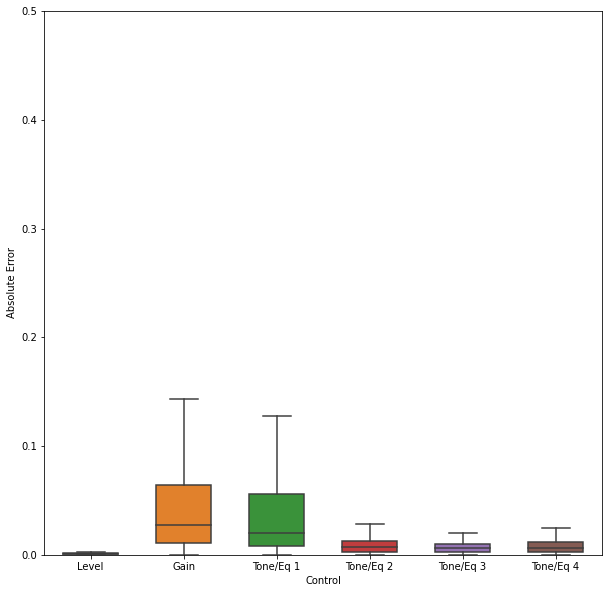

In [17]:
plt.figure(figsize=(10,10))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(df), width=0.6, showfliers = False, fliersize=2)
# ax = sns.swarmplot(x="variable", y="value", data=pd.melt(df), color=".25")
ax.set(xlabel="Control", ylabel = "Absolute Error")
ax.set(ylim=(0,0.5))

In [18]:
mt2 = test_df[test_df['filename'].str.contains('MT2')]
mt2 = pd.DataFrame(data={'Level': mt2.level_abs,
                        'Gain': mt2.gain_abs,
                        'Tone/Eq 1': mt2.tone_eq1_abs,
                        'Tone/Eq 2': mt2.tone_eq2_abs,
                        'Tone/Eq 3': mt2.tone_eq3_abs,
                        'Tone/Eq 4': mt2.tone_eq4_abs,
                        })
mt2

,Level,Gain,Tone/Eq 1,Tone/Eq 2,Tone/Eq 3,Tone/Eq 4
0,0.001,0.034,0.001,0.008,0.013,0.035
5,0.002,0.081,0.005,0.006,0.004,0.019
18,0.002,0.009,0.015,0.032,0.003,0.039
20,0.001,0.065,0.006,0.024,0.007,0.005
28,0.003,0.070,0.001,0.005,0.017,0.033
...,...,...,...,...,...,...
32678,0.003,0.003,0.012,0.016,0.014,0.059
32679,0.001,0.063,0.001,0.028,0.003,0.032
32681,0.003,0.024,0.005,0.002,0.003,0.029
32688,0.001,0.025,0.007,0.005,0.033,0.022


[(0.0, 0.5)]

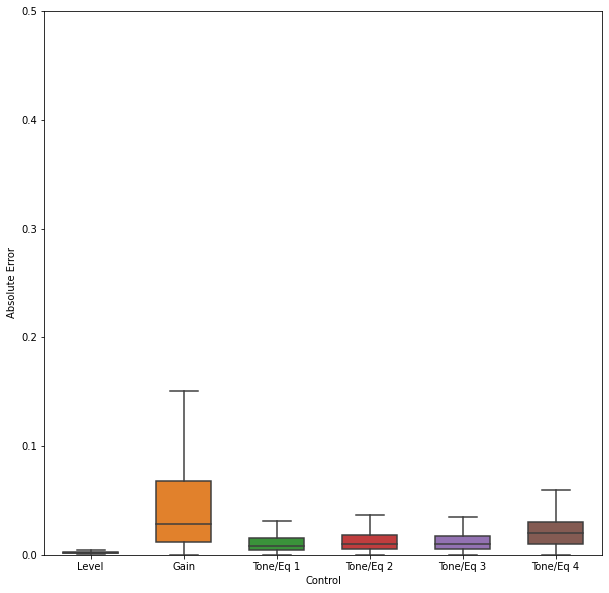

In [20]:
plt.figure(figsize=(10,10))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(mt2), width=0.6, showfliers = False, fliersize=2)
# ax = sns.swarmplot(x="variable", y="value", data=pd.melt(mt2), color=".25")
ax.set(xlabel="Control", ylabel = "Absolute Error")
ax.set(ylim=(0,0.5))

<AxesSubplot:xlabel='gain_pred'>

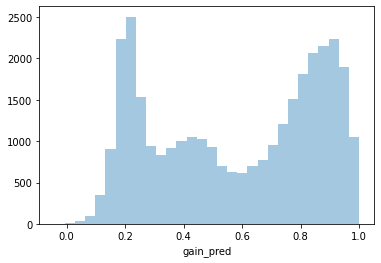

In [19]:
sns.distplot(test_df['gain_pred'], kde=False, hist=True, rug=False)

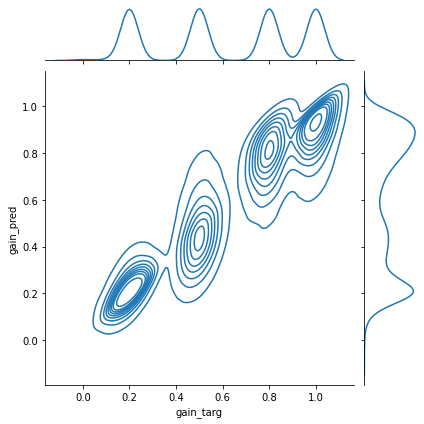

In [20]:
sns.jointplot(x='gain_targ', y='gain_pred', data=test_df, kind='kde');

### TEST on MONO RANDOM

In [21]:
# dataset
dataset_mono_rnd = dataset.FxDataset(
                            root='/Volumes/Macintosh HD/DATASETS/GUITAR-FX/Mono_Random',
                            excl_folders=['NoFX_mono_preprocessed'], 
                            spectra_folder='mel_22050_1024_512', 
                            processed_settings_csv='proc_settings.csv',
                            max_num_settings=6,
                            transform=transforms.Compose([transforms.ToTensor()])
                            )

dataset_mono_rnd.init_dataset()
# dataset_mono_rnd.generate_mel()

# split
# set test_train_split=0.0 and val_train_split=0.0 to test pre-trained model
split_mono_rnd = datasplit.DataSplit(dataset_mono_rnd, test_train_split=0.0, val_train_split=0.0, shuffle=True)

# loaders
_, _, test_loader_mono_rnd = split_mono_rnd.get_split(batch_size=100)

In [22]:
len(dataset_mono_rnd)

14000

In [25]:
test_mono_rnd_loss, test_mono_rnd_correct, test_mono_rnd_results = trainer.test_settings_cond_net(
        model=setnetcond, 
        test_loader=test_loader_mono_rnd, 
        test_sampler=split_mono_rnd.test_sampler,
        loss_function=nn.MSELoss(), 
        device='cpu'
    )

====> Test Loss: 1.9859	 Avg Loss: 0.0001	Correct: 7860/14000	Percentage Correct: 56.14


In [26]:
test_mono_rnd_results[0]

(7546,
 'G81-70511-MT2-G1B3.3T1.8ML7.5MF9.3-20968',
 array([0.997, 0.202, 0.04 , 0.124, 0.1  , 0.817], dtype=float32),
 array([1.  , 0.1 , 0.33, 0.18, 0.75, 0.93], dtype=float32))

In [27]:
# dataframe
test_mono_rnd_results_npy = np.array(test_mono_rnd_results)
test_indexes = test_mono_rnd_results_npy[:, 0]
test_filenames = test_mono_rnd_results_npy[:, 1] 
test_preds = np.stack(test_mono_rnd_results_npy[:, 2])
test_targets = np.stack(test_mono_rnd_results_npy[:, 3])
test_abs_err = np.stack(abs(test_preds - test_targets))

test_mono_rnd_df = pd.DataFrame(data={'index': test_indexes, 'filename': test_filenames,
                                'level_pred': test_preds[:,0], 'gain_pred': test_preds[:,1],
                                'tone_eq1_pred': test_preds[:,2], 'tone_eq2_pred': test_preds[:,3],
                                'tone_eq3_pred': test_preds[:,4], 'tone_eq4_pred': test_preds[:,5],
                                'level_targ': test_targets[:,0], 'gain_targ': test_targets[:,1],
                                'tone_eq1_targ': test_targets[:,2], 'tone_eq2_targ': test_targets[:,3],
                                'tone_eq3_targ': test_targets[:,4], 'tone_eq4_targ': test_targets[:,5],
                                'level_abs': test_abs_err[:,0], 'gain_abs': test_abs_err[:,1],
                                'tone_eq1_abs': test_abs_err[:,2], 'tone_eq2_abs': test_abs_err[:,3],
                                'tone_eq3_abs': test_abs_err[:,4], 'tone_eq4_abs': test_abs_err[:,5]})
test_mono_rnd_df

,index,filename,level_pred,gain_pred,tone_eq1_pred,tone_eq2_pred,tone_eq3_pred,tone_eq4_pred,level_targ,gain_targ,tone_eq1_targ,tone_eq2_targ,tone_eq3_targ,tone_eq4_targ,level_abs,gain_abs,tone_eq1_abs,tone_eq2_abs,tone_eq3_abs,tone_eq4_abs
0,7546,G81-70511-MT2-G1B3.3T1.8ML7.5MF9.3-20968,0.997,0.202,0.040,0.124,0.100,0.817,1.0,0.10,0.33,0.18,0.75,0.93,0.003,0.102,0.290,0.056,0.650,0.113
1,5358,G91-47107-FFC-F0.5-21068,1.001,0.111,-0.988,-0.973,-0.985,-0.997,1.0,0.05,-1.00,-1.00,-1.00,-1.00,0.001,0.061,0.012,0.027,0.015,0.003
2,13281,G61-66411-VTB-F1.1-20643,1.001,0.128,-1.022,-0.986,-0.999,-1.011,1.0,0.15,-1.00,-1.00,-1.00,-1.00,0.001,0.022,0.022,0.014,0.001,0.011
3,9152,G91-70606-RAT-D6F6-21132,1.001,0.612,0.670,-0.999,-0.995,-1.001,1.0,0.60,0.60,-1.00,-1.00,-1.00,0.001,0.012,0.070,0.001,0.005,0.001
4,1135,G83-61502-BD2-G7.9T9.7-21037,1.002,0.799,0.871,-1.005,-0.998,-1.009,1.0,0.79,0.97,-1.00,-1.00,-1.00,0.002,0.009,0.099,0.005,0.002,0.009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,1933,G91-56306-BD2-G8.6T7.1-21093,1.002,0.769,0.411,-1.014,-1.006,-1.018,1.0,0.86,0.71,-1.00,-1.00,-1.00,0.002,0.091,0.299,0.014,0.006,0.018
13996,6207,G63-64409-MGS-D0.2T1.4-20719,1.001,0.171,0.170,-0.977,-0.989,-0.998,1.0,0.02,0.14,-1.00,-1.00,-1.00,0.001,0.151,0.030,0.023,0.011,0.002
13997,3392,G93-53303-DPL-D7.1-21168,1.002,0.728,-1.032,-0.993,-1.002,-1.012,1.0,0.71,-1.00,-1.00,-1.00,-1.00,0.002,0.018,0.032,0.007,0.002,0.012
13998,2999,G91-51206-BMF-S7.2T3.3-21080,1.001,0.760,0.321,-0.997,-0.998,-1.001,1.0,0.72,0.33,-1.00,-1.00,-1.00,0.001,0.040,0.009,0.003,0.002,0.001


In [28]:
# Mean Absolute Errors
level_mae_mono_rnd = sum(test_mono_rnd_df.level_abs)/len(dataset_mono_rnd)
gain_mae_mono_rnd = sum(test_mono_rnd_df.gain_abs)/len(dataset_mono_rnd)
tone_eq1_mae_mono_rnd = sum(test_mono_rnd_df.tone_eq1_abs)/len(dataset_mono_rnd)
tone_eq2_mae_mono_rnd = sum(test_mono_rnd_df.tone_eq2_abs)/len(dataset_mono_rnd)
tone_eq3_mae_mono_rnd = sum(test_mono_rnd_df.tone_eq3_abs)/len(dataset_mono_rnd)
tone_eq4_mae_mono_rnd = sum(test_mono_rnd_df.tone_eq4_abs)/len(dataset_mono_rnd)
print('level_mae: ', level_mae_mono_rnd)
print('gain_mae: ', gain_mae_mono_rnd)
print('tone_eq1_mae: ', tone_eq1_mae_mono_rnd)
print('tone_eq2_mae: ', tone_eq2_mae_mono_rnd)
print('tone_eq3_mae: ', tone_eq3_mae_mono_rnd)
print('tone_eq4_mae: ', tone_eq4_mae_mono_rnd)

level_mae:  0.0012958791511399406
gain_mae:  0.06955771439761987
tone_eq1_mae:  0.09397178554954007
tone_eq2_mae:  0.03601592897397599
tone_eq3_mae:  0.03256685769870611
tone_eq4_mae:  0.03614628505001643


In [34]:
abs_err_df = pd.DataFrame(data={'Level': test_df.level_abs,
                        'Gain': test_df.gain_abs,
                        'Tone/Eq 1': test_df.tone_eq1_abs,
                        'Tone/Eq 2': test_df.tone_eq2_abs,
                        'Tone/Eq 3': test_df.tone_eq3_abs,
                        'Tone/Eq 4': test_df.tone_eq4_abs,
                        })
abs_err_df

,Level,Gain,Tone/Eq 1,Tone/Eq 2,Tone/Eq 3,Tone/Eq 4
0,0.001,0.034,0.001,0.008,0.013,0.035
1,0.002,0.070,0.102,0.006,0.003,0.007
2,0.002,0.026,0.089,0.002,0.004,0.006
3,0.002,0.055,0.025,0.016,0.007,0.015
4,0.002,0.061,0.035,0.002,0.009,0.002
...,...,...,...,...,...,...
32693,0.001,0.001,0.103,0.002,0.001,0.003
32694,0.003,0.049,0.005,0.007,0.014,0.015
32695,0.000,0.032,0.163,0.011,0.003,0.006
32696,0.001,0.091,0.026,0.002,0.008,0.004


[(0.0, 0.35)]

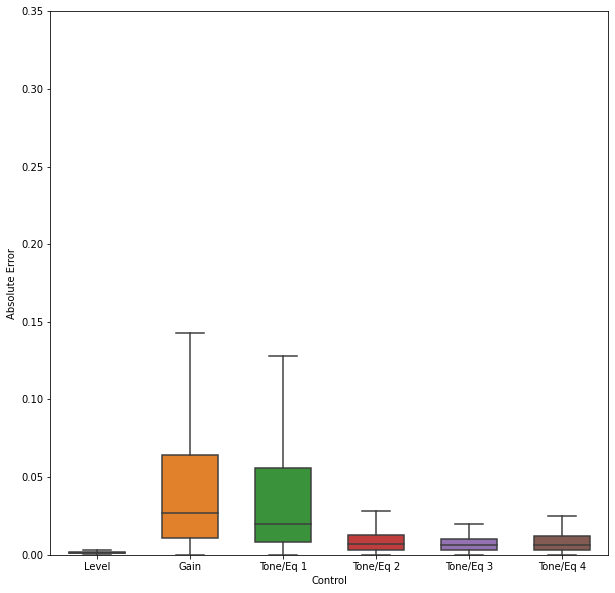

In [35]:
plt.figure(figsize=(10,10))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(abs_err_df), width=0.6, showfliers = False, fliersize=2)
# ax = sns.swarmplot(x="variable", y="value", data=pd.melt(df), color=".25")
ax.set(xlabel="Control", ylabel = "Absolute Error")
ax.set(ylim=(0,0.35))

In [43]:
one_fx_df = test_mono_rnd_df[test_mono_rnd_df['filename'].str.contains('808')]
one_fx_df = pd.DataFrame(data={'Level': one_fx_df.level_abs,
                        'Gain': one_fx_df.gain_abs,
                        'Tone/Eq 1': one_fx_df.tone_eq1_abs,
                        'Tone/Eq 2': one_fx_df.tone_eq2_abs,
                        'Tone/Eq 3': one_fx_df.tone_eq3_abs,
                        'Tone/Eq 4': one_fx_df.tone_eq4_abs,
                        })
one_fx_df

,Level,Gain,Tone/Eq 1,Tone/Eq 2,Tone/Eq 3,Tone/Eq 4
61,0.000,0.093,0.171,0.020,0.009,0.002
63,0.001,0.016,0.335,0.008,0.003,0.000
85,0.001,0.010,0.157,0.002,0.003,0.009
104,0.001,0.101,0.231,0.012,0.004,0.000
112,0.001,0.013,0.033,0.003,0.000,0.003
...,...,...,...,...,...,...
13964,0.001,0.034,0.161,0.010,0.006,0.004
13977,0.001,0.042,0.127,0.006,0.002,0.000
13979,0.001,0.043,0.298,0.001,0.002,0.004
13981,0.001,0.200,0.284,0.005,0.004,0.007


[(0.0, 1.0)]

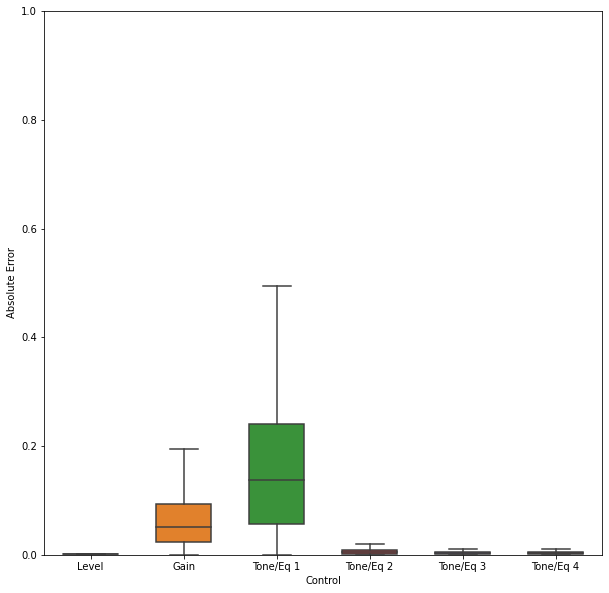

In [44]:
plt.figure(figsize=(10,10))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(one_fx_df), width=0.6, showfliers = False, fliersize=2)
# ax = sns.swarmplot(x="variable", y="value", data=pd.melt(mt2), color=".25")
ax.set(xlabel="Control", ylabel = "Absolute Error")
ax.set(ylim=(0,1))

### TEST on POLY

In [46]:
# dataset
dataset_poly = dataset.FxDataset(
                            root='/Volumes/Macintosh HD/DATASETS/GUITAR-FX/Poly',
                            excl_folders=['NoFX_poly'], 
                            spectra_folder='mel_22050_1024_512', 
                            processed_settings_csv='proc_settings.csv',
                            max_num_settings=6,
                            transform=transforms.Compose([transforms.ToTensor()])
                            )

dataset_poly.init_dataset()
# dataset_mono_rnd.generate_mel()

# split
# set test_train_split=0.0 and val_train_split=0.0 to test pre-trained model
split_poly = datasplit.DataSplit(dataset_poly, test_train_split=0.0, val_train_split=0.0, shuffle=True)

# loaders
_, _, test_loader_poly = split_poly.get_split(batch_size=100)

In [47]:
len(dataset_poly)

110040

In [48]:
test_poly_loss, test_poly_correct, test_poly_results = trainer.test_settings_cond_net(
        model=setnetcond, 
        test_loader=test_loader_poly, 
        test_sampler=split_poly.test_sampler,
        loss_function=nn.MSELoss(), 
        device='cpu'
    )

====> Test Loss: 143.4524	 Avg Loss: 0.0013	Correct: 320/110040	Percentage Correct: 0.29


In [49]:
# dataframe
test_poly_results_npy = np.array(test_poly_results)
test_indexes = test_poly_results_npy[:, 0]
test_filenames = test_poly_results_npy[:, 1] 
test_preds = np.stack(test_poly_results_npy[:, 2])
test_targets = np.stack(test_poly_results_npy[:, 3])
test_abs_err = np.stack(abs(test_preds - test_targets))

test_poly_df = pd.DataFrame(data={'index': test_indexes, 'filename': test_filenames,
                                'level_pred': test_preds[:,0], 'gain_pred': test_preds[:,1],
                                'tone_eq1_pred': test_preds[:,2], 'tone_eq2_pred': test_preds[:,3],
                                'tone_eq3_pred': test_preds[:,4], 'tone_eq4_pred': test_preds[:,5],
                                'level_targ': test_targets[:,0], 'gain_targ': test_targets[:,1],
                                'tone_eq1_targ': test_targets[:,2], 'tone_eq2_targ': test_targets[:,3],
                                'tone_eq3_targ': test_targets[:,4], 'tone_eq4_targ': test_targets[:,5],
                                'level_abs': test_abs_err[:,0], 'gain_abs': test_abs_err[:,1],
                                'tone_eq1_abs': test_abs_err[:,2], 'tone_eq2_abs': test_abs_err[:,3],
                                'tone_eq3_abs': test_abs_err[:,4], 'tone_eq4_abs': test_abs_err[:,5]})
test_poly_df

,index,filename,level_pred,gain_pred,tone_eq1_pred,tone_eq2_pred,tone_eq3_pred,tone_eq4_pred,level_targ,gain_targ,tone_eq1_targ,tone_eq2_targ,tone_eq3_targ,tone_eq4_targ,level_abs,gain_abs,tone_eq1_abs,tone_eq2_abs,tone_eq3_abs,tone_eq4_abs
0,103223,P64-50120-TS9-D10T10-41207,1.001,0.216,0.786,-0.864,-0.883,-0.897,1.0,1.0,1.0,-1.0,-1.0,-1.0,0.001,0.784,0.214,0.136,0.117,0.103
1,79775,P95-56250-RAT-D5F8-41573,0.999,0.255,0.301,-0.772,-0.771,-0.763,1.0,0.5,0.8,-1.0,-1.0,-1.0,0.001,0.245,0.499,0.228,0.229,0.237
2,52103,P95-50240-MT2-G8B0T0ML10MF10-41552,0.997,0.233,0.060,-0.127,0.758,0.351,1.0,0.8,0.0,0.0,1.0,1.0,0.003,0.567,0.060,0.127,0.242,0.649
3,4659,P65-47210-808-O8T5-41294,1.000,0.211,0.131,-0.881,-0.892,-0.905,1.0,0.8,0.5,-1.0,-1.0,-1.0,0.000,0.589,0.369,0.119,0.108,0.095
4,86412,P64-43150-RBM-T5S8-41245,1.000,0.340,0.325,-0.862,-0.870,-0.880,1.0,0.8,0.5,-1.0,-1.0,-1.0,0.000,0.460,0.175,0.138,0.130,0.120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110035,43763,P64-52140-MGS-D2T10-41239,1.000,0.236,-0.061,-0.861,-0.867,-0.880,1.0,0.2,1.0,-1.0,-1.0,-1.0,0.000,0.036,1.061,0.139,0.133,0.120
110036,85105,P94-52150-RBM-T5S5-41464,1.000,0.381,0.250,-0.876,-0.875,-0.885,1.0,0.5,0.5,-1.0,-1.0,-1.0,0.000,0.119,0.250,0.124,0.125,0.115
110037,64309,P65-49250-MT2-G8B10T0ML10MF10-41356,0.998,0.267,0.091,-0.089,0.374,0.173,1.0,0.8,1.0,0.0,1.0,1.0,0.002,0.533,0.909,0.089,0.626,0.827
110038,15647,P94-52150-BD2-G8T0-41464,1.000,0.189,0.596,-0.863,-0.877,-0.893,1.0,0.8,0.0,-1.0,-1.0,-1.0,0.000,0.611,0.596,0.137,0.123,0.107


In [50]:
# Mean Absolute Errors
level_mae_poly = sum(test_poly_df.level_abs)/len(dataset_poly)
gain_mae_poly = sum(test_poly_df.gain_abs)/len(dataset_poly)
tone_eq1_mae_poly = sum(test_poly_df.tone_eq1_abs)/len(dataset_poly)
tone_eq2_mae_poly = sum(test_poly_df.tone_eq2_abs)/len(dataset_poly)
tone_eq3_mae_poly = sum(test_poly_df.tone_eq3_abs)/len(dataset_poly)
tone_eq4_mae_poly = sum(test_poly_df.tone_eq4_abs)/len(dataset_poly)
print('level_mae: ', level_mae_poly)
print('gain_mae: ', gain_mae_poly)
print('tone_eq1_mae: ', tone_eq1_mae_poly)
print('tone_eq2_mae: ', tone_eq2_mae_poly)
print('tone_eq3_mae: ', tone_eq3_mae_poly)
print('tone_eq4_mae: ', tone_eq4_mae_poly)

level_mae:  0.0011701761587495502
gain_mae:  0.398496704288802
tone_eq1_mae:  0.3136297183107956
tone_eq2_mae:  0.1920058979094549
tone_eq3_mae:  0.25003451474635086
tone_eq4_mae:  0.2681875227866852


In [51]:
poly_abs_err_df = pd.DataFrame(data={'Level': test_poly_df.level_abs,
                        'Gain': test_poly_df.gain_abs,
                        'Tone/Eq 1': test_poly_df.tone_eq1_abs,
                        'Tone/Eq 2': test_poly_df.tone_eq2_abs,
                        'Tone/Eq 3': test_poly_df.tone_eq3_abs,
                        'Tone/Eq 4': test_poly_df.tone_eq4_abs,
                        })
poly_abs_err_df

,Level,Gain,Tone/Eq 1,Tone/Eq 2,Tone/Eq 3,Tone/Eq 4
0,0.001,0.784,0.214,0.136,0.117,0.103
1,0.001,0.245,0.499,0.228,0.229,0.237
2,0.003,0.567,0.060,0.127,0.242,0.649
3,0.000,0.589,0.369,0.119,0.108,0.095
4,0.000,0.460,0.175,0.138,0.130,0.120
...,...,...,...,...,...,...
110035,0.000,0.036,1.061,0.139,0.133,0.120
110036,0.000,0.119,0.250,0.124,0.125,0.115
110037,0.002,0.533,0.909,0.089,0.626,0.827
110038,0.000,0.611,0.596,0.137,0.123,0.107


[Text(0.5, 0, 'Control'), Text(0, 0.5, 'Absolute Error')]

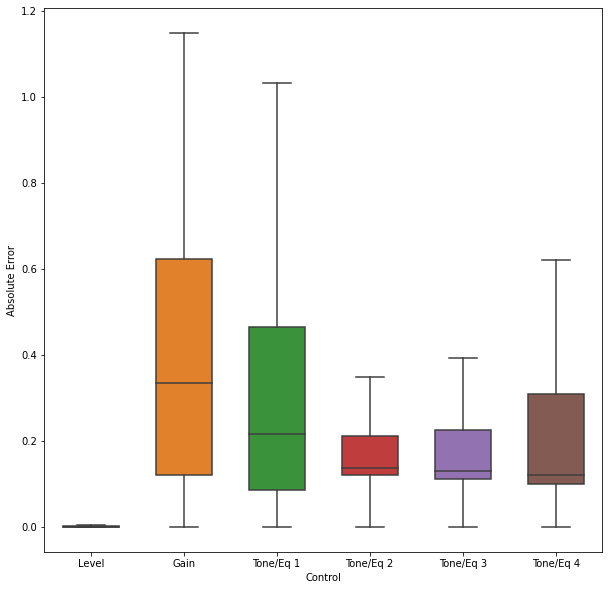

In [53]:
plt.figure(figsize=(10,10))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(poly_abs_err_df), width=0.6, showfliers = False, fliersize=2)
# ax = sns.swarmplot(x="variable", y="value", data=pd.melt(df), color=".25")
ax.set(xlabel="Control", ylabel = "Absolute Error")
# ax.set(ylim=(0,1))

### TEST on POLY RANDOM

In [54]:
# dataset
dataset_poly_rnd = dataset.FxDataset(
                            root='/Volumes/Macintosh HD/DATASETS/GUITAR-FX/Poly_Random',
                            excl_folders=['NoFX_poly'], 
                            spectra_folder='mel_22050_1024_512', 
                            processed_settings_csv='proc_settings.csv',
                            max_num_settings=6,
                            transform=transforms.Compose([transforms.ToTensor()])
                            )

dataset_poly_rnd.init_dataset()
# dataset_mono_rnd.generate_mel()

# split
# set test_train_split=0.0 and val_train_split=0.0 to test pre-trained model
split_poly_rnd = datasplit.DataSplit(dataset_poly_rnd, test_train_split=0.0, val_train_split=0.0, shuffle=True)

# loaders
_, _, test_loader_poly_rnd = split_poly_rnd.get_split(batch_size=100)

In [55]:
len(dataset_poly_rnd)

14000

In [56]:
test_poly_rnd_loss, test_poly_rnd_correct, test_poly_rnd_results = trainer.test_settings_cond_net(
        model=setnetcond, 
        test_loader=test_loader_poly_rnd, 
        test_sampler=split_poly_rnd.test_sampler,
        loss_function=nn.MSELoss(), 
        device='cpu'
    )

====> Test Loss: 13.7777	 Avg Loss: 0.0010	Correct: 10/14000	Percentage Correct: 0.07


In [ ]:
# dataframe
test_poly_rnd_results_npy = np.array(test_poly_rnd_results)
test_indexes = test_poly_rnd_results_npy[:, 0]
test_filenames = test_poly_rnd_results_npy[:, 1] 
test_preds = np.stack(test_poly_rnd_results_npy[:, 2])
test_targets = np.stack(test_poly_rnd_results_npy[:, 3])
test_abs_err = np.stack(abs(test_preds - test_targets))

test_poly_rnd_df = pd.DataFrame(data={'index': test_indexes, 'filename': test_filenames,
                                'level_pred': test_preds[:,0], 'gain_pred': test_preds[:,1],
                                'tone_eq1_pred': test_preds[:,2], 'tone_eq2_pred': test_preds[:,3],
                                'tone_eq3_pred': test_preds[:,4], 'tone_eq4_pred': test_preds[:,5],
                                'level_targ': test_targets[:,0], 'gain_targ': test_targets[:,1],
                                'tone_eq1_targ': test_targets[:,2], 'tone_eq2_targ': test_targets[:,3],
                                'tone_eq3_targ': test_targets[:,4], 'tone_eq4_targ': test_targets[:,5],
                                'level_abs': test_abs_err[:,0], 'gain_abs': test_abs_err[:,1],
                                'tone_eq1_abs': test_abs_err[:,2], 'tone_eq2_abs': test_abs_err[:,3],
                                'tone_eq3_abs': test_abs_err[:,4], 'tone_eq4_abs': test_abs_err[:,5]})
test_poly_rnd_df

In [19]:
# SAVE RESULTS for best epoch

# write train results to csv file
train_results_sorted = all_train_results[best_val_idx].tolist()
for i in range(len(train_results_sorted)):
    train_results_sorted[i][0] = int(train_results_sorted[i][0])
train_results_sorted = sorted(train_results_sorted)
with open('%s/%s/%s' % (results_folder, model_name, 'train_setnet_results.csv'), mode='w') as file:
    wrt = csv.writer(file)
    wrt.writerow(['index','filename','prediction','settings'])
    for row in train_results_sorted:
        wrt.writerow(row)

# write validation results to csv file
val_results_sorted = all_val_results[best_val_idx].tolist()
for i in range(len(val_results_sorted)):
    val_results_sorted[i][0] = int(val_results_sorted[i][0])
val_results_sorted = sorted(val_results_sorted)
with open('%s/%s/%s' % (results_folder, model_name, 'val_setnet_results.csv'), mode='w') as file:
    wrt = csv.writer(file)
    wrt.writerow(['index','filename','prediction','settings'])
    for row in val_results_sorted:
        wrt.writerow(row)

# write test results to csv file
test_results_sorted = all_test_results[best_val_idx].tolist()
for i in range(len(test_results_sorted)):
    test_results_sorted[i][0] = int(test_results_sorted[i][0])
test_results_sorted = sorted(test_results_sorted)
with open('%s/%s/%s' % (results_folder, model_name, 'test_setnet_results.csv'), mode='w') as file:
    wrt = csv.writer(file)
    wrt.writerow(['index','filename','prediction','settings'])
    for row in test_results_sorted:
        wrt.writerow(row)